# Итоговый проект по курсу OTUS "ML для финансового анализа" 2024-07

### 1. Задача - провести анализ исторических данных котировок криптовалют (на примере ETH) с использованием инструментов машинного обучения и нейронных сетей для предсказания торговых действий на бирже (покупка, продажа)

### 2. Сбор и очистка данных

In [1126]:
class COMMON_CONFIG:
    CASH = 1_000_000
    COMMISSION = .002
    SEED = 777
    SYMBOL = 'ETH/USDT'
    TIMEFRAME = '1h'
    START_DATE = '2020-01-01T00:00:00Z'
    VAL_DATA_OFFSET = 2,
    TEST_DATA_OFFSET = 1,
    ML_TARGET_NEXT_PERIOD_OFFSET = -24
    TA_MAX_STAT = 'Return [%]'

In [932]:
!pip install matplotlib -q
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

!pip install pandas -q
import pandas as pd
# Хак чтобы работало на Anaconda под MacOs 10.15.7 Catalina
pd.DataFrame.iteritems = pd.DataFrame.items

In [824]:
!pip install plotly -q

import plotly.graph_objects as go

def linear_plot(df, title):
    fig = go.Figure([go.Scatter(x=df['date'], y=df['close'], mode='lines')])
    fig.update_layout(plot_bgcolor='white',
                      xaxis_title='Date',
                      yaxis_title='Price',
                      title=title)
    fig.show()

def candlestick_plot(df, title):
    fig = go.Figure([go.Candlestick(x=df['date'],
                                open=df['open'],
                                high=df['high'],
                                low=df['low'],
                                close=df['close'])])
    fig.update_layout(xaxis_rangeslider_visible=False,
                      plot_bgcolor='white',
                      xaxis_title='Date',
                      yaxis_title='Price',
                      title=title)
    fig.update_yaxes(fixedrange=False)
    fig.show()

In [825]:
!pip install git+https://github.com/kernc/backtesting.py.git -q

from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA

def run_backtest(_test_data, _strategy, plot=True, print_stats=True):
  bt = Backtest(_test_data, _strategy, cash=COMMON_CONFIG.CASH, commission=COMMON_CONFIG.COMMISSION)
  stats = bt.run()
  
  if plot:
    bt.plot()
      
  if print_stats:
    print(stats)
  return stats

In [1000]:
!pip install torch -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [1001]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import random
import numpy as np

def seed_everything(seed: int = COMMON_CONFIG.SEED) -> None:
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
    print(f"Using {seed} seed")

# Зафиксируем SEED
seed_everything(COMMON_CONFIG.SEED)

Using 777 seed


In [834]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


#### Загрузим данные

In [835]:
!pip install ccxt -q

import ccxt
import time

def get_data_from_api(symbol, timeframe, since):
    exchange = ccxt.binance()
    since = exchange.parse8601(since)
    all_ohlcvs = []

    while True:
        try:
            ohlcvs = exchange.fetch_ohlcv(symbol, timeframe, since)
            all_ohlcvs += ohlcvs
            if len(ohlcvs):
                print('Fetched', len(ohlcvs), symbol, timeframe, 'candles from', exchange.iso8601(ohlcvs[0][0]))
                since = ohlcvs[-1][0] + 1
                sleep_interval = exchange.rateLimit / 1000
                print('Sleep for', sleep_interval)
                time.sleep(sleep_interval)
            else:
                break
        except Exception as e:
            print(type(e).__name__, str(e))
    print('Fetched', len(all_ohlcvs), symbol, timeframe, 'candles in total')
    return pd.DataFrame(all_ohlcvs)

In [836]:
def save_data_to_file(_data, _symbol, _timeframe):
    _data.columns = ['date','open','high','low','close','volume']
    _data = _data.sort_values(by='date')
    _data = _data.drop_duplicates(subset='date').reset_index(drop=True)
    _data['date'] = pd.to_datetime(_data['date'], unit='ms')
    _data.to_csv(_symbol.replace('/', '_') + '_' + _timeframe + '.csv', index=False)

In [837]:
def read_data_from_file(_symbol, _timeframe):
    _df = pd.read_csv(_symbol.replace('/', '_') + '_' + _timeframe + '.csv')
    _df = _df.sort_values(by='date')
    _df = _df.drop_duplicates(subset='date').reset_index(drop=True)
    _df['date'] = pd.to_datetime(_df['date'])
    _df.set_index('date', inplace=True)
    # Удалим значения где нет объемов
    _df = _df.drop(_df[_df['volume']==0.0].index)
    return _df

In [838]:
def convert_data_to_bt_format(_data):
    _df = _data.copy()
    _df.columns = _df.columns.str.capitalize()
    _df.rename(columns={'Date': 'Datetime'}, inplace=True)
    _df["Datetime"] = pd.to_datetime(_df["Datetime"])
    _df.set_index('Datetime', inplace=True)
    return _df

In [1002]:
df = get_data_from_api(COMMON_CONFIG.SYMBOL, COMMON_CONFIG.TIMEFRAME, COMMON_CONFIG.START_DATE)
save_data_to_file(df, COMMON_CONFIG.SYMBOL, COMMON_CONFIG.TIMEFRAME)
df

Fetched 500 ETH/USDT 1d candles from 2020-01-01T00:00:00.000Z
Sleep for 0.05
Fetched 500 ETH/USDT 1d candles from 2021-05-15T00:00:00.000Z
Sleep for 0.05
Fetched 500 ETH/USDT 1d candles from 2022-09-27T00:00:00.000Z
Sleep for 0.05
Fetched 346 ETH/USDT 1d candles from 2024-02-09T00:00:00.000Z
Sleep for 0.05
Fetched 1846 ETH/USDT 1d candles in total


date       open       high        low      close       volume
0     1577836800000  129.16000  133.05000  128.68000  130.77000 144770.52197
1     1577923200000  130.72000  130.78000  126.38000  127.19000 213757.05806
2     1578009600000  127.19000  135.14000  125.88000  134.35000 413055.18895
3     1578096000000  134.37000  135.85000  132.50000  134.20000 184276.17102
4     1578182400000  134.20000  138.19000  134.19000  135.37000 254120.45343
...             ...        ...        ...        ...        ...          ...
1841  1736899200000 3225.63000 3473.75000 3186.36000 3451.52000 464188.03400
1842  1736985600000 3451.51000 3460.79000 3265.44000 3308.05000 471282.67870
1843  1737072000000 3308.04000 3525.72000 3307.50000 3473.63000 518550.18130
1844  1737158400000 3473.64000 3494.39000 3227.00000 3307.71000 634197.12810
1845  1737244800000 3307.71000 3389.28000 3130.48000 3381.02000 730954.17340

[1846 rows x 6 columns]

In [1127]:
df = read_data_from_file(COMMON_CONFIG.SYMBOL, COMMON_CONFIG.TIMEFRAME)
df

open       high        low      close       volume
date                                                                        
2020-01-01 00:00:00  129.16000  129.19000  128.68000  128.87000   7769.17336
2020-01-01 01:00:00  128.87000  130.65000  128.78000  130.64000  11344.65516
2020-01-01 02:00:00  130.63000  130.98000  130.35000  130.85000   7603.35623
2020-01-01 03:00:00  130.85000  130.89000  129.94000  130.20000   4968.55433
2020-01-01 04:00:00  130.21000  130.74000  130.15000  130.20000   3397.90747
...                        ...        ...        ...        ...          ...
2025-01-19 09:00:00 3221.90000 3233.77000 3143.02000 3226.00000 105144.51170
2025-01-19 10:00:00 3226.01000 3226.89000 3172.97000 3174.70000  51453.00680
2025-01-19 11:00:00 3174.70000 3188.90000 3130.48000 3149.97000  50955.62760
2025-01-19 12:00:00 3149.98000 3211.55000 3145.00000 3205.90000  38838.69030
2025-01-19 13:00:00 3205.90000 3221.60000 3202.13000 3220.79000   8762.74570

[44260 rows x 5 columns]

In [1128]:
linear_plot(df.reset_index(), 'ETH/USDT')

In [1129]:
#Сформируем данные для бэктестинга
#Удаляем последнюю строку, так как в данных для ML обучения из-за сдвига будет расхождение в датах
df_for_bt = df.copy()[:COMMON_CONFIG.ML_TARGET_NEXT_PERIOD_OFFSET]
df_for_bt

open       high        low      close      volume
date                                                                       
2020-01-01 00:00:00  129.16000  129.19000  128.68000  128.87000  7769.17336
2020-01-01 01:00:00  128.87000  130.65000  128.78000  130.64000 11344.65516
2020-01-01 02:00:00  130.63000  130.98000  130.35000  130.85000  7603.35623
2020-01-01 03:00:00  130.85000  130.89000  129.94000  130.20000  4968.55433
2020-01-01 04:00:00  130.21000  130.74000  130.15000  130.20000  3397.90747
...                        ...        ...        ...        ...         ...
2025-01-18 09:00:00 3293.21000 3301.20000 3252.80000 3270.97000 26513.29410
2025-01-18 10:00:00 3270.97000 3278.42000 3227.00000 3267.10000 55640.29000
2025-01-18 11:00:00 3267.09000 3324.10000 3249.10000 3311.62000 38230.54920
2025-01-18 12:00:00 3311.63000 3322.44000 3274.17000 3289.90000 30302.68720
2025-01-18 13:00:00 3289.90000 3323.53000 3280.04000 3323.38000 23027.91150

[44236 rows x 5 columns]

In [938]:
!pip install summarytools -q

from summarytools import dfSummary

dfSummary(df)

In [939]:
df.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [940]:
df.describe()

open        high         low       close       volume
count 44260.00000 44260.00000 44260.00000 44260.00000  44260.00000
mean   1994.98040  2005.83637  1983.35232  1995.04949  26825.06174
std    1150.26549  1156.43395  1143.56119  1150.24641  29153.53202
min      96.51000   105.69000    86.00000    96.62000    161.74877
25%    1259.40250  1265.52500  1251.79750  1259.45500  10124.08685
50%    1875.85000  1881.93000  1869.11000  1875.85500  18146.38408
75%    2928.28000  2942.78250  2912.41000  2928.38750  32664.06663
max    4846.94000  4868.00000  4833.19000  4846.71000 493227.88282

#### Посмотрим на базовое поведение модели на основе самой простой стратегии скользящих средних

In [1008]:
class SmaCross(Strategy):
    n1 = 10
    n2 = 20
    
    def init(self):
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        if crossover(self.sma1, self.sma2):
            self.position.close()
            self.buy()

        elif crossover(self.sma2, self.sma1):
            self.position.close()
            self.sell()

In [1016]:
bt_data = convert_data_to_bt_format(df_for_bt.reset_index())
bt_data

Open       High        Low      Close       Volume
Datetime                                                           
2020-01-01  129.16000  133.05000  128.68000  130.77000 144770.52197
2020-01-02  130.72000  130.78000  126.38000  127.19000 213757.05806
2020-01-03  127.19000  135.14000  125.88000  134.35000 413055.18895
2020-01-04  134.37000  135.85000  132.50000  134.20000 184276.17102
2020-01-05  134.20000  138.19000  134.19000  135.37000 254120.45343
...               ...        ...        ...        ...          ...
2025-01-14 3137.51000 3256.67000 3125.65000 3225.63000 374308.45170
2025-01-15 3225.63000 3473.75000 3186.36000 3451.52000 464188.03400
2025-01-16 3451.51000 3460.79000 3265.44000 3308.05000 471282.67870
2025-01-17 3308.04000 3525.72000 3307.50000 3473.63000 518550.18130
2025-01-18 3473.64000 3494.39000 3227.00000 3307.71000 634197.12810

[1845 rows x 5 columns]

In [1017]:
def train_test_split(_data):
    # Определяем дату начала тестовой выборки
    _test_start_date = _data.index.max() - pd.DateOffset(months=int(COMMON_CONFIG.TEST_DATA_OFFSET[0]))

    # Разделение данных на тренировочную и тестовую выборки по времени
    _train_data = _data[_data.index < _test_start_date]
    _test_data = _data[_data.index >= _test_start_date]

    print(f"Train size: {len(_train_data)}, Test size: {len(_test_data)}")
    return _train_data, _test_data

In [944]:
def train_test_split_by_date(_data):
    # Определяем дату начала тестовой выборки
    _test_start_date = _data['date'].max() - pd.DateOffset(months=int(COMMON_CONFIG.TEST_DATA_OFFSET[0]))

    # Определяем дату начала валидационной выборки
    _val_start_date = data['date'].max() - pd.DateOffset(months=COMMON_CONFIG.VAL_DATA_OFFSET[0])

    # Разделение данных на тренировочную, валидационную и тестовую выборки по времени
    _train_data = _data[_data['date'] < _val_start_date]
    _val_data = data[(data['date'] >= _val_start_date) & (data['date'] < _test_start_date)]
    _test_data = _data[_data['date'] >= _test_start_date]

    print(f"Train size: {len(_train_data)}, Val size: {len(_val_data)}, Test size: {len(_test_data)}")
    return _train_data, _val_data, _test_data

In [1018]:
bt_train_data, bt_test_data = train_test_split(bt_data)

Train size: 1478, Test size: 367


In [1019]:
bt_test_data

Open       High        Low      Close       Volume
Datetime                                                           
2024-01-18 2530.20000 2550.00000 2428.56000 2470.81000 452090.10740
2024-01-19 2470.81000 2504.20000 2415.20000 2492.00000 424209.00290
2024-01-20 2491.99000 2492.00000 2454.20000 2472.01000 136620.95770
2024-01-21 2472.02000 2482.18000 2452.13000 2457.05000 122572.16870
2024-01-22 2457.06000 2466.10000 2303.59000 2314.20000 526337.64920
...               ...        ...        ...        ...          ...
2025-01-14 3137.51000 3256.67000 3125.65000 3225.63000 374308.45170
2025-01-15 3225.63000 3473.75000 3186.36000 3451.52000 464188.03400
2025-01-16 3451.51000 3460.79000 3265.44000 3308.05000 471282.67870
2025-01-17 3308.04000 3525.72000 3307.50000 3473.63000 518550.18130
2025-01-18 3473.64000 3494.39000 3227.00000 3307.71000 634197.12810

[367 rows x 5 columns]

In [1020]:
_ = run_backtest(bt_test_data, SmaCross)

Start                     2024-01-18 00:00:00
End                       2025-01-18 00:00:00
Duration                    366 days 00:00:00
Exposure Time [%]                    94.27793
Equity Final [$]                 911872.67862
Equity Peak [$]                 1671927.38602
Return [%]                           -8.81273
Buy & Hold Return [%]                33.87148
Return (Ann.) [%]                    -8.76688
Volatility (Ann.) [%]                60.75825
Sharpe Ratio                         -0.14429
Sortino Ratio                        -0.19914
Calmar Ratio                         -0.19285
Max. Drawdown [%]                   -45.45979
Avg. Drawdown [%]                    -6.14977
Max. Drawdown Duration      313 days 00:00:00
Avg. Drawdown Duration       37 days 00:00:00
# Trades                                   20
Win Rate [%]                         45.00000
Best Trade [%]                       43.74181
Worst Trade [%]                     -16.98534
Avg. Trade [%]                    

### 3. Технический анализ

In [1021]:
#python должен быть версии 3.6-3.9 для установки numpy==1.19.5. Эта версия нужна для работы ta-lib
!pip uninstall -y numpy
!pip install numpy==1.24.4 -q

import numpy as np

Found existing installation: numpy 1.24.4
Uninstalling numpy-1.24.4:
  Successfully uninstalled numpy-1.24.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.13.1 requires numpy<=1.24.3,>=1.22, but you have numpy 1.24.4 which is incompatible.
tensorflow 2.13.1 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.12.2 which is incompatible.


In [949]:
# работа выполнялась на MacOS 10.15
# предварительно запустить brew install ta-lib
!pip install TA-Lib -q

import talib

In [950]:
class TechAnalysisStrategy(Strategy):
    def init(self):
        self.signal = self.I(lambda: self.data.Signal)
        self.previous_signal = 0

    def next(self):
        current_signal = self.signal[-1]

        if current_signal != self.previous_signal:
            if current_signal == 1:
                if self.position.is_short:
                    self.position.close()

                if not self.position.is_long:
                    self.buy()

            elif current_signal == -1:
                if self.position.is_long:
                    self.position.close()

                if not self.position.is_short:
                    self.sell()

            elif current_signal == 0:
                if self.position:
                    self.position.close()

        self.previous_signal = current_signal

In [951]:
def enrich_with_ta(_data, _params):
    """
    Обогащение данных значениями технического анализа

    :param data: DataFrame с данными, на которые будут наложены индикаторы.
    :param params: словарь с параметрами.
    :return: DataFrame с рассчитанными индикаторами и сигналами.
    """
    _df = _data.copy()
    # Извлекаем параметры из словаря
    tema_period = _params['tema_period']
    fastMACD_period = _params['fastMACD_period']
    slowMACD_period = _params['slowMACD_period']
    signalMACD_period = _params['signalMACD_period']

    # Добавляем индикаторы
    _close = _df['close'].values
    _df['tema'] = talib.TEMA(_close, timeperiod=tema_period)
    _df['macd'], _df['macd_signal'], _df['macd_hist'] = talib.MACD(_close, fastperiod=fastMACD_period, slowperiod=slowMACD_period, signalperiod=signalMACD_period)
    return _df, ['tema', 'macd', 'macd_signal', 'macd_hist']

In [952]:
def get_trade_signals(_data):
    _df = _data.copy()
    
    # Создаем сигналы для покупки и продажи
    _df['signal'] = 0
    _df.loc[(_df['macd'] > _df['macd_signal']) & (_df['close'] > _df['tema']), 'signal'] = 1  # Сигнал на покупку
    _df.loc[(_df['macd'] < _df['macd_signal']) & (_df['close'] < _df['tema']), 'signal'] = -1  # Сигнал на продажу
    return _df[["date", "open", "high", "low", "close", "volume", "signal"]]

In [1022]:
ta_data, _ = enrich_with_ta(df_for_bt.reset_index(), {
    'tema_period': 30,
    'fastMACD_period': 12,
    'slowMACD_period': 26,
    'signalMACD_period': 9
})
ta_data

date       open       high        low      close       volume  \
0    2020-01-01  129.16000  133.05000  128.68000  130.77000 144770.52197   
1    2020-01-02  130.72000  130.78000  126.38000  127.19000 213757.05806   
2    2020-01-03  127.19000  135.14000  125.88000  134.35000 413055.18895   
3    2020-01-04  134.37000  135.85000  132.50000  134.20000 184276.17102   
4    2020-01-05  134.20000  138.19000  134.19000  135.37000 254120.45343   
...         ...        ...        ...        ...        ...          ...   
1840 2025-01-14 3137.51000 3256.67000 3125.65000 3225.63000 374308.45170   
1841 2025-01-15 3225.63000 3473.75000 3186.36000 3451.52000 464188.03400   
1842 2025-01-16 3451.51000 3460.79000 3265.44000 3308.05000 471282.67870   
1843 2025-01-17 3308.04000 3525.72000 3307.50000 3473.63000 518550.18130   
1844 2025-01-18 3473.64000 3494.39000 3227.00000 3307.71000 634197.12810   

           tema      macd  macd_signal  macd_hist  
0           NaN       NaN          NaN        NaN  
1           NaN       NaN          NaN        NaN  
2           NaN       NaN          NaN        NaN  
3           NaN       NaN          NaN        NaN  
4           NaN       NaN          NaN        NaN  
...         ...       ...          ...        ...  
1840 3226.47967 -80.47730    -54.43360  -26.04370  
1841 3248.72793 -64.12029    -56.37094   -7.74935  
1842 3242.88013 -62.01916    -57.50058   -4.51858  
1843 3268.44389 -46.45754    -55.29197    8.83443  
1844 3261.34075 -46.97174    -53.62793    6.65619  

[1845 rows x 10 columns]

In [1023]:
data_with_ta_signals = get_trade_signals(ta_data)
data_with_ta_signals

date       open       high        low      close       volume  \
0    2020-01-01  129.16000  133.05000  128.68000  130.77000 144770.52197   
1    2020-01-02  130.72000  130.78000  126.38000  127.19000 213757.05806   
2    2020-01-03  127.19000  135.14000  125.88000  134.35000 413055.18895   
3    2020-01-04  134.37000  135.85000  132.50000  134.20000 184276.17102   
4    2020-01-05  134.20000  138.19000  134.19000  135.37000 254120.45343   
...         ...        ...        ...        ...        ...          ...   
1840 2025-01-14 3137.51000 3256.67000 3125.65000 3225.63000 374308.45170   
1841 2025-01-15 3225.63000 3473.75000 3186.36000 3451.52000 464188.03400   
1842 2025-01-16 3451.51000 3460.79000 3265.44000 3308.05000 471282.67870   
1843 2025-01-17 3308.04000 3525.72000 3307.50000 3473.63000 518550.18130   
1844 2025-01-18 3473.64000 3494.39000 3227.00000 3307.71000 634197.12810   

      signal  
0          0  
1          0  
2          0  
3          0  
4          0  
...      ...  
1840      -1  
1841       0  
1842       0  
1843       1  
1844       1  

[1845 rows x 7 columns]

In [1024]:
bt_data = convert_data_to_bt_format(data_with_ta_signals)
bt_data

Open       High        Low      Close       Volume  Signal
Datetime                                                                   
2020-01-01  129.16000  133.05000  128.68000  130.77000 144770.52197       0
2020-01-02  130.72000  130.78000  126.38000  127.19000 213757.05806       0
2020-01-03  127.19000  135.14000  125.88000  134.35000 413055.18895       0
2020-01-04  134.37000  135.85000  132.50000  134.20000 184276.17102       0
2020-01-05  134.20000  138.19000  134.19000  135.37000 254120.45343       0
...               ...        ...        ...        ...          ...     ...
2025-01-14 3137.51000 3256.67000 3125.65000 3225.63000 374308.45170      -1
2025-01-15 3225.63000 3473.75000 3186.36000 3451.52000 464188.03400       0
2025-01-16 3451.51000 3460.79000 3265.44000 3308.05000 471282.67870       0
2025-01-17 3308.04000 3525.72000 3307.50000 3473.63000 518550.18130       1
2025-01-18 3473.64000 3494.39000 3227.00000 3307.71000 634197.12810       1

[1845 rows x 6 columns]

In [1025]:
bt_train_data, bt_test_data = train_test_split(bt_data)

Train size: 1478, Test size: 367


In [1026]:
_ = run_backtest(bt_test_data, TechAnalysisStrategy)

Start                     2024-01-18 00:00:00
End                       2025-01-18 00:00:00
Duration                    366 days 00:00:00
Exposure Time [%]                    89.91826
Equity Final [$]                 930714.64728
Equity Peak [$]                 2031188.07424
Return [%]                           -6.92854
Buy & Hold Return [%]                33.87148
Return (Ann.) [%]                    -6.89211
Volatility (Ann.) [%]                55.52199
Sharpe Ratio                         -0.12413
Sortino Ratio                        -0.18558
Calmar Ratio                         -0.12416
Max. Drawdown [%]                   -55.50855
Avg. Drawdown [%]                   -10.31294
Max. Drawdown Duration      164 days 00:00:00
Avg. Drawdown Duration       32 days 00:00:00
# Trades                                   48
Win Rate [%]                         33.33333
Best Trade [%]                       23.98543
Worst Trade [%]                     -12.54941
Avg. Trade [%]                    

In [1027]:
import itertools

def get_best_params(_data, _strategy, _max_stat_param):
    # Задаем возможные значения для параметров
    tema_period_list = [7, 14, 28, 48]
    fastMACD_period_list = [12, 35, 56]
    slowMACD_period_list = [9, 26, 39]
    signalMACD_period_list = [9, 20, 40, 80]

    # Для хранения лучших параметров и лучшего результата
    best_params = None
    best_performance = -float('inf')

    # Проходим по всем комбинациям параметров
    for tema_period, fastMACD_period, slowMACD_period, signalMACD_period in itertools.product(tema_period_list, fastMACD_period_list, slowMACD_period_list, signalMACD_period_list):

        # Создаем словарь с текущими параметрами
        params = {
            'tema_period': tema_period,
            'fastMACD_period': fastMACD_period,
            'slowMACD_period': slowMACD_period,
            'signalMACD_period': signalMACD_period
        }

        _ta_data, _ = enrich_with_ta(_data, params)
        _data_with_signals = get_trade_signals(_ta_data)
        _bt_data = convert_data_to_bt_format(_data_with_signals)
        
        print(f"Выполняем backtesting для параметров {params}")
        _stats = run_backtest(_bt_data, _strategy, plot=False, print_stats=False)

        # Определяем метрику, по которой будем выбирать лучшую стратегию
        performance = _stats[_max_stat_param]
        print(f"Получен результат {performance}")

        # Сравниваем с лучшим результатом и сохраняем лучшие параметры
        if performance > best_performance:
            best_performance = performance
            best_params = params

    print(f"Лучший параметр статистики {_max_stat_param}: {best_performance}")
    print(f"Лучшие параметры технического анализа: {best_params}")
    return best_params

In [1028]:
best_ta_params = get_best_params(df_for_bt.reset_index(), TechAnalysisStrategy, COMMON_CONFIG.TA_MAX_STAT)

Выполняем backtesting для параметров {'tema_period': 7, 'fastMACD_period': 12, 'slowMACD_period': 9, 'signalMACD_period': 9}
Получен результат -60.110685342000124
Выполняем backtesting для параметров {'tema_period': 7, 'fastMACD_period': 12, 'slowMACD_period': 9, 'signalMACD_period': 20}
Получен результат -41.62923453000006
Выполняем backtesting для параметров {'tema_period': 7, 'fastMACD_period': 12, 'slowMACD_period': 9, 'signalMACD_period': 40}
Получен результат 63.68028372599986
Выполняем backtesting для параметров {'tema_period': 7, 'fastMACD_period': 12, 'slowMACD_period': 9, 'signalMACD_period': 80}
Получен результат 23.12658707399976
Выполняем backtesting для параметров {'tema_period': 7, 'fastMACD_period': 12, 'slowMACD_period': 26, 'signalMACD_period': 9}
Получен результат -37.160285538000146
Выполняем backtesting для параметров {'tema_period': 7, 'fastMACD_period': 12, 'slowMACD_period': 26, 'signalMACD_period': 20}
Получен результат -8.096483626000024
Выполняем backtesting 

In [1174]:
ta_data, _ = enrich_with_ta(df_for_bt.reset_index(), best_ta_params)
data_with_signals = get_trade_signals(ta_data)
bt_data = convert_data_to_bt_format(data_with_signals)
bt_best_params_train_data, bt_best_params_test_data = train_test_split(bt_data)
_ = run_backtest(bt_best_params_test_data, TechAnalysisStrategy)

Train size: 43491, Test size: 745


Start                     2024-12-18 13:00:00
End                       2025-01-18 13:00:00
Duration                     31 days 00:00:00
Exposure Time [%]                    52.21477
Equity Final [$]                 926325.94542
Equity Peak [$]                 1118011.81406
Return [%]                           -7.36741
Buy & Hold Return [%]               -13.80628
Return (Ann.) [%]                   -68.76377
Volatility (Ann.) [%]                16.36821
Sharpe Ratio                         -4.20106
Sortino Ratio                        -1.96414
Calmar Ratio                         -3.21625
Max. Drawdown [%]                   -21.38011
Avg. Drawdown [%]                    -5.56379
Max. Drawdown Duration       29 days 02:00:00
Avg. Drawdown Duration        6 days 04:00:00
# Trades                                   98
Win Rate [%]                         28.57143
Best Trade [%]                        7.03790
Worst Trade [%]                      -3.12476
Avg. Trade [%]                    

In [1030]:
bt_best_params_test_data

Open       High        Low      Close       Volume  Signal
2024-01-18 2530.20000 2550.00000 2428.56000 2470.81000 452090.10740       0
2024-01-19 2470.81000 2504.20000 2415.20000 2492.00000 424209.00290       0
2024-01-20 2491.99000 2492.00000 2454.20000 2472.01000 136620.95770       0
2024-01-21 2472.02000 2482.18000 2452.13000 2457.05000 122572.16870       0
2024-01-22 2457.06000 2466.10000 2303.59000 2314.20000 526337.64920      -1
...               ...        ...        ...        ...          ...     ...
2025-01-14 3137.51000 3256.67000 3125.65000 3225.63000 374308.45170       0
2025-01-15 3225.63000 3473.75000 3186.36000 3451.52000 464188.03400       0
2025-01-16 3451.51000 3460.79000 3265.44000 3308.05000 471282.67870       0
2025-01-17 3308.04000 3525.72000 3307.50000 3473.63000 518550.18130       0
2025-01-18 3473.64000 3494.39000 3227.00000 3307.71000 634197.12810      -1

[367 rows x 6 columns]

### 4. Машинное обучение

In [1130]:
!pip install scikit-learn -q

import numpy as np

# Функция для добавления целевой переменной (таргета)
def add_target(df):
    df['close_next_period'] = df['close'].shift(COMMON_CONFIG.ML_TARGET_NEXT_PERIOD_OFFSET)
    df['target'] = (df['close_next_period'] > df['close']).astype(int)
    df = df.dropna(subset=['close_next_period'])
    return df

# Фильтрация строк, где таргет не определён (например, NaN в close_next_period)
def filter_invalid_targets(df):
    # Удаляем строки, где close_next_period или target равен NaN
    return df.dropna(subset=['close_next_period', 'target'])

#### Обучение моделей будем производить, добавив доп признаки тех анализа

In [1131]:
ta_data, ta_columns = enrich_with_ta(df.reset_index(), best_ta_params)
ta_data

date       open       high        low      close  \
0     2020-01-01 00:00:00  129.16000  129.19000  128.68000  128.87000   
1     2020-01-01 01:00:00  128.87000  130.65000  128.78000  130.64000   
2     2020-01-01 02:00:00  130.63000  130.98000  130.35000  130.85000   
3     2020-01-01 03:00:00  130.85000  130.89000  129.94000  130.20000   
4     2020-01-01 04:00:00  130.21000  130.74000  130.15000  130.20000   
...                   ...        ...        ...        ...        ...   
44255 2025-01-19 09:00:00 3221.90000 3233.77000 3143.02000 3226.00000   
44256 2025-01-19 10:00:00 3226.01000 3226.89000 3172.97000 3174.70000   
44257 2025-01-19 11:00:00 3174.70000 3188.90000 3130.48000 3149.97000   
44258 2025-01-19 12:00:00 3149.98000 3211.55000 3145.00000 3205.90000   
44259 2025-01-19 13:00:00 3205.90000 3221.60000 3202.13000 3220.79000   

            volume       tema     macd  macd_signal  macd_hist  
0       7769.17336        NaN      NaN          NaN        NaN  
1      11344.65516        NaN      NaN          NaN        NaN  
2       7603.35623        NaN      NaN          NaN        NaN  
3       4968.55433        NaN      NaN          NaN        NaN  
4       3397.90747        NaN      NaN          NaN        NaN  
...            ...        ...      ...          ...        ...  
44255 105144.51170 3253.52829 -3.37941     -1.87959   -1.49982  
44256  51453.00680 3222.39292 -3.96154     -2.07787   -1.88367  
44257  50955.62760 3190.96264 -4.61023     -2.31905   -2.29118  
44258  38838.69030 3187.72214 -4.86872     -2.56188   -2.30685  
44259   8762.74570 3191.42600 -5.00440     -2.79450   -2.20990  

[44260 rows x 10 columns]

In [1132]:
def create_trend_features(df, features, lag_periods):
    """
    Добавляет классические финансовые признаки: отношение к предыдущим периодам, логарифмические изменения и индикаторы трендов.
    
    df: DataFrame с исходными данными
    features: список признаков, для которых необходимо добавить индикаторы
    lag_periods: сколько периодов назад учитывать для расчетов
    
    Возвращает:
    - обновленный DataFrame с новыми фичами
    - список новых колонок, которые можно использовать как признаки
    """
    df = df.copy()  # Работаем с копией DataFrame
    new_columns = []  # Список для хранения новых колонок
    
    for feature in features:
        # Отношение текущего значения к предыдущему (лаг = 1)
        df[f'{feature}_ratio_1'] = df[feature] / df[feature].shift(1)
        new_columns.append(f'{feature}_ratio_1')
        
        # Логарифмическое изменение (логарифм отношения текущего значения к предыдущему)
        df[f'{feature}_log_diff_1'] = np.log(df[feature] / df[feature].shift(1))
        new_columns.append(f'{feature}_log_diff_1')
        
        # Momentum (разница между текущим значением и значением N периодов назад)
        df[f'{feature}_momentum_{lag_periods}'] = df[feature] - df[feature].shift(lag_periods)
        new_columns.append(f'{feature}_momentum_{lag_periods}')
        
        # Rate of Change (ROC): процентное изменение за N периодов
        df[f'{feature}_roc_{lag_periods}'] = (df[feature] - df[feature].shift(lag_periods)) / df[feature].shift(lag_periods) * 100
        new_columns.append(f'{feature}_roc_{lag_periods}')
        
        # Exponential Moving Average (EMA) с периодом N
        df[f'{feature}_ema_{lag_periods}'] = df[feature].ewm(span=lag_periods, adjust=False).mean()
        new_columns.append(f'{feature}_ema_{lag_periods}')
    
    # Удаление строк с NaN значениями, которые появились из-за сдвигов
    df = df.dropna()
    
    return df, new_columns

In [1133]:
def create_lag_features(df, features, lag_periods):
    """
    Добавляет лаги для указанных признаков на указанное количество периодов назад.
    
    df: DataFrame с исходными данными
    features: список признаков, для которых необходимо добавить лаги
    lag_periods: сколько лагов назад необходимо создать
    Возвращает: 
    - обновленный DataFrame с лагами
    - список новых колонок, которые можно использовать как признаки
    """
    df = df.copy()  # Работаем с копией DataFrame
    new_columns = []  # Список для хранения новых колонок
    
    # Для каждого признака создаем лаги
    for feature in features:
        for lag in range(1, lag_periods + 1):
            new_col_name = f'{feature}_lag_{lag}'
            df[new_col_name] = df[feature].shift(lag)
            new_columns.append(new_col_name)
    
    # Удаляем строки с NaN значениями, которые появились из-за сдвигов
    df = df.dropna()
    
    return df, new_columns

In [1134]:
# Добавляем целевую переменную (таргет)
ta_data_with_target = filter_invalid_targets(add_target(ta_data))

# Параметры для создания трендовых признаков
lag_periods = 72  # Например, 3 периода назад
#features_to_trend = ['open', 'high', 'low', 'close', 'volume']
features_to_trend = ['close']
features_to_lag = ['close']

# Создаем трендовые признаки
ta_data_with_target_and_trend, new_trend_features = create_trend_features(ta_data_with_target, features_to_trend, lag_periods)

ta_data_with_target_and_trend

date       open       high        low      close  \
72    2020-01-04 00:00:00  134.37000  134.81000  133.44000  133.70000   
73    2020-01-04 01:00:00  133.71000  133.71000  132.79000  133.01000   
74    2020-01-04 02:00:00  133.01000  133.48000  132.80000  133.47000   
75    2020-01-04 03:00:00  133.47000  133.54000  133.18000  133.34000   
76    2020-01-04 04:00:00  133.34000  133.91000  133.00000  133.67000   
...                   ...        ...        ...        ...        ...   
44231 2025-01-18 09:00:00 3293.21000 3301.20000 3252.80000 3270.97000   
44232 2025-01-18 10:00:00 3270.97000 3278.42000 3227.00000 3267.10000   
44233 2025-01-18 11:00:00 3267.09000 3324.10000 3249.10000 3311.62000   
44234 2025-01-18 12:00:00 3311.63000 3322.44000 3274.17000 3289.90000   
44235 2025-01-18 13:00:00 3289.90000 3323.53000 3280.04000 3323.38000   

           volume       tema     macd  macd_signal  macd_hist  \
72    11609.95948  134.11063  0.14054      0.06154    0.07900   
73     7514.41101  133.85996  0.14180      0.06918    0.07262   
74     5970.26181  133.81487  0.14510      0.07641    0.06869   
75     4705.93094  133.72141  0.14694      0.08313    0.06381   
76     8118.69367  133.75433  0.15001      0.08950    0.06051   
...           ...        ...      ...          ...        ...   
44231 26513.29410 3275.21000  1.29462      4.15397   -2.85935   
44232 55640.29000 3259.44583  0.61248      3.81668   -3.20421   
44233 38230.54920 3264.50379  0.24607      3.47663   -3.23056   
44234 30302.68720 3262.02522 -0.20403      3.12609   -3.33011   
44235 23027.91150 3273.03858 -0.42130      2.78824   -3.20954   

       close_next_period  target  close_ratio_1  close_log_diff_1  \
72             134.76000       1        0.99516          -0.00485   
73             135.65000       1        0.99484          -0.00517   
74             135.46000       1        1.00346           0.00345   
75             136.16000       1        0.99903          -0.00097   
76             135.91000       1        1.00247           0.00247   
...                  ...     ...            ...               ...   
44231         3226.00000       0        0.99325          -0.00678   
44232         3174.70000       0        0.99882          -0.00118   
44233         3149.97000       0        1.01363           0.01353   
44234         3205.90000       0        0.99344          -0.00658   
44235         3220.79000       0        1.01018           0.01013   

       close_momentum_72  close_roc_72  close_ema_72  
72               4.83000       3.74796     130.59080  
73               2.37000       1.81415     130.65708  
74               2.62000       2.00229     130.73414  
75               3.14000       2.41167     130.80554  
76               3.47000       2.66513     130.88402  
...                  ...           ...           ...  
44231           71.45000       2.23315    3355.79372  
44232           57.60000       1.79467    3353.36375  
44233          112.02000       3.50106    3352.22009  
44234           87.27000       2.72495    3350.51269  
44235           24.44000       0.74084    3349.76933  

[44164 rows x 17 columns]

In [1135]:
# Создаем лаги в данных
ta_data_with_target_and_trend_and_lags, lags_columns = create_lag_features(ta_data_with_target_and_trend, features_to_lag, lag_periods)
ta_data_with_target_and_trend_and_lags

date       open       high        low      close  \
144   2020-01-07 00:00:00  144.14000  145.31000  143.16000  143.77000   
145   2020-01-07 01:00:00  143.76000  144.16000  143.36000  143.83000   
146   2020-01-07 02:00:00  143.85000  144.88000  143.82000  143.98000   
147   2020-01-07 03:00:00  143.97000  144.41000  143.48000  143.50000   
148   2020-01-07 04:00:00  143.50000  143.62000  142.15000  142.49000   
...                   ...        ...        ...        ...        ...   
44231 2025-01-18 09:00:00 3293.21000 3301.20000 3252.80000 3270.97000   
44232 2025-01-18 10:00:00 3270.97000 3278.42000 3227.00000 3267.10000   
44233 2025-01-18 11:00:00 3267.09000 3324.10000 3249.10000 3311.62000   
44234 2025-01-18 12:00:00 3311.63000 3322.44000 3274.17000 3289.90000   
44235 2025-01-18 13:00:00 3289.90000 3323.53000 3280.04000 3323.38000   

           volume       tema     macd  macd_signal  macd_hist  ...  \
144   47783.52094  143.52329  0.31233      0.26459    0.04774  ...   
145   14921.42870  143.81769  0.31863      0.26974    0.04889  ...   
146   14591.56948  144.06527  0.32423      0.27493    0.04930  ...   
147    7255.17955  144.05752  0.32569      0.27976    0.04593  ...   
148   15652.73032  143.67432  0.32048      0.28364    0.03684  ...   
...           ...        ...      ...          ...        ...  ...   
44231 26513.29410 3275.21000  1.29462      4.15397   -2.85935  ...   
44232 55640.29000 3259.44583  0.61248      3.81668   -3.20421  ...   
44233 38230.54920 3264.50379  0.24607      3.47663   -3.23056  ...   
44234 30302.68720 3262.02522 -0.20403      3.12609   -3.33011  ...   
44235 23027.91150 3273.03858 -0.42130      2.78824   -3.20954  ...   

       close_lag_63  close_lag_64  close_lag_65  close_lag_66  close_lag_67  \
144       134.13000     133.60000     133.91000     133.95000     133.66000   
145       133.40000     134.13000     133.60000     133.91000     133.95000   
146       133.77000     133.40000     134.13000     133.60000     133.91000   
147       132.79000     133.77000     133.40000     134.13000     133.60000   
148       132.90000     132.79000     133.77000     133.40000     134.13000   
...             ...           ...           ...           ...           ...   
44231    3372.31000    3325.81000    3339.49000    3334.47000    3329.48000   
44232    3434.99000    3372.31000    3325.81000    3339.49000    3334.47000   
44233    3434.01000    3434.99000    3372.31000    3325.81000    3339.49000   
44234    3432.41000    3434.01000    3434.99000    3372.31000    3325.81000   
44235    3430.78000    3432.41000    3434.01000    3434.99000    3372.31000   

       close_lag_68  close_lag_69  close_lag_70  close_lag_71  close_lag_72  
144       133.67000     133.34000     133.47000     133.01000     133.70000  
145       133.66000     133.67000     133.34000     133.47000     133.01000  
146       133.95000     133.66000     133.67000     133.34000     133.47000  
147       133.91000     133.95000     133.66000     133.67000     133.34000  
148       133.60000     133.91000     133.95000     133.66000     133.67000  
...             ...           ...           ...           ...           ...  
44231    3298.94000    3202.63000    3199.60000    3209.50000    3199.52000  
44232    3329.48000    3298.94000    3202.63000    3199.60000    3209.50000  
44233    3334.47000    3329.48000    3298.94000    3202.63000    3199.60000  
44234    3339.49000    3334.47000    3329.48000    3298.94000    3202.63000  
44235    3325.81000    3339.49000    3334.47000    3329.48000    3298.94000  

[44092 rows x 89 columns]

In [1136]:
ml_columns = new_trend_features + ta_columns + lags_columns# + features_to_trend
ml_columns

['close_ratio_1',
 'close_log_diff_1',
 'close_momentum_72',
 'close_roc_72',
 'close_ema_72',
 'tema',
 'macd',
 'macd_signal',
 'macd_hist',
 'close_lag_1',
 'close_lag_2',
 'close_lag_3',
 'close_lag_4',
 'close_lag_5',
 'close_lag_6',
 'close_lag_7',
 'close_lag_8',
 'close_lag_9',
 'close_lag_10',
 'close_lag_11',
 'close_lag_12',
 'close_lag_13',
 'close_lag_14',
 'close_lag_15',
 'close_lag_16',
 'close_lag_17',
 'close_lag_18',
 'close_lag_19',
 'close_lag_20',
 'close_lag_21',
 'close_lag_22',
 'close_lag_23',
 'close_lag_24',
 'close_lag_25',
 'close_lag_26',
 'close_lag_27',
 'close_lag_28',
 'close_lag_29',
 'close_lag_30',
 'close_lag_31',
 'close_lag_32',
 'close_lag_33',
 'close_lag_34',
 'close_lag_35',
 'close_lag_36',
 'close_lag_37',
 'close_lag_38',
 'close_lag_39',
 'close_lag_40',
 'close_lag_41',
 'close_lag_42',
 'close_lag_43',
 'close_lag_44',
 'close_lag_45',
 'close_lag_46',
 'close_lag_47',
 'close_lag_48',
 'close_lag_49',
 'close_lag_50',
 'close_lag_51',

In [1137]:
data = ta_data_with_target_and_trend_and_lags[ml_columns + ['target', 'date']]
data

close_ratio_1  close_log_diff_1  close_momentum_72  close_roc_72  \
144          0.99736          -0.00264           10.07000       7.53179   
145          1.00042           0.00042           10.82000       8.13473   
146          1.00104           0.00104           10.51000       7.87443   
147          0.99667          -0.00334           10.16000       7.61962   
148          0.99296          -0.00706            8.82000       6.59834   
...              ...               ...                ...           ...   
44231        0.99325          -0.00678           71.45000       2.23315   
44232        0.99882          -0.00118           57.60000       1.79467   
44233        1.01363           0.01353          112.02000       3.50106   
44234        0.99344          -0.00658           87.27000       2.72495   
44235        1.01018           0.01013           24.44000       0.74084   

       close_ema_72       tema     macd  macd_signal  macd_hist  close_lag_1  \
144       137.50913  143.52329  0.31233      0.26459    0.04774    144.15000   
145       137.68230  143.81769  0.31863      0.26974    0.04889    143.77000   
146       137.85484  144.06527  0.32423      0.27493    0.04930    143.83000   
147       138.00950  144.05752  0.32569      0.27976    0.04593    143.98000   
148       138.13226  143.67432  0.32048      0.28364    0.03684    143.50000   
...             ...        ...      ...          ...        ...          ...   
44231    3355.79372 3275.21000  1.29462      4.15397   -2.85935   3293.21000   
44232    3353.36375 3259.44583  0.61248      3.81668   -3.20421   3270.97000   
44233    3352.22009 3264.50379  0.24607      3.47663   -3.23056   3267.10000   
44234    3350.51269 3262.02522 -0.20403      3.12609   -3.33011   3311.62000   
44235    3349.76933 3273.03858 -0.42130      2.78824   -3.20954   3289.90000   

       ...  close_lag_65  close_lag_66  close_lag_67  close_lag_68  \
144    ...     133.91000     133.95000     133.66000     133.67000   
145    ...     133.60000     133.91000     133.95000     133.66000   
146    ...     134.13000     133.60000     133.91000     133.95000   
147    ...     133.40000     134.13000     133.60000     133.91000   
148    ...     133.77000     133.40000     134.13000     133.60000   
...    ...           ...           ...           ...           ...   
44231  ...    3339.49000    3334.47000    3329.48000    3298.94000   
44232  ...    3325.81000    3339.49000    3334.47000    3329.48000   
44233  ...    3372.31000    3325.81000    3339.49000    3334.47000   
44234  ...    3434.99000    3372.31000    3325.81000    3339.49000   
44235  ...    3434.01000    3434.99000    3372.31000    3325.81000   

       close_lag_69  close_lag_70  close_lag_71  close_lag_72  target  \
144       133.34000     133.47000     133.01000     133.70000       1   
145       133.67000     133.34000     133.47000     133.01000       1   
146       133.66000     133.67000     133.34000     133.47000       1   
147       133.95000     133.66000     133.67000     133.34000       1   
148       133.91000     133.95000     133.66000     133.67000       1   
...             ...           ...           ...           ...     ...   
44231    3202.63000    3199.60000    3209.50000    3199.52000       0   
44232    3298.94000    3202.63000    3199.60000    3209.50000       0   
44233    3329.48000    3298.94000    3202.63000    3199.60000       0   
44234    3334.47000    3329.48000    3298.94000    3202.63000       0   
44235    3339.49000    3334.47000    3329.48000    3298.94000       0   

                     date  
144   2020-01-07 00:00:00  
145   2020-01-07 01:00:00  
146   2020-01-07 02:00:00  
147   2020-01-07 03:00:00  
148   2020-01-07 04:00:00  
...                   ...  
44231 2025-01-18 09:00:00  
44232 2025-01-18 10:00:00  
44233 2025-01-18 11:00:00  
44234 2025-01-18 12:00:00  
44235 2025-01-18 13:00:00  

[44092 rows x 83 columns]

In [1138]:
train_data, val_data, test_data = train_test_split_by_date(data)

Train size: 42627, Val size: 720, Test size: 745


In [1139]:
# Разделение на признаки (X) и целевую переменную (y) для каждой выборки
X_train = train_data[ml_columns]
y_train = train_data['target']

X_val = train_data[ml_columns]
y_val = train_data['target']

X_test = test_data[ml_columns]
y_test = test_data['target']

#### Определим метрики качества моделей

In [1140]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score

def calculate_metrics_table(y_true, y_pred_prob, thresholds=[0.5, 0.6, 0.7, 0.8]):
    metrics_table = []
    
    for threshold in thresholds:
        y_pred = (y_pred_prob >= threshold).astype(int)
        metrics = {
            'Cutoff': threshold,
            'Precision': precision_score(y_true, y_pred),
            'Recall': recall_score(y_true, y_pred),
            'Accuracy': accuracy_score(y_true, y_pred),
            'F1-Score': f1_score(y_true, y_pred)
        }
        metrics_table.append(metrics)
    
    # Преобразуем список словарей в DataFrame для удобного вывода
    return pd.DataFrame(metrics_table)*100

In [1101]:
# Выводим ROC AUC и метрики для всех выборок
def display_metrics_set(name, y_true, y_pred_prob):
    roc_auc = roc_auc_score(y_true, y_pred_prob)
    print(f"\n=== Метрики для {name} выборки ===")
    print(f"ROC AUC: {roc_auc:.4f}")
    metrics_table = calculate_metrics_table(y_true, y_pred_prob)
    print(metrics_table)

In [1102]:
def predict(_model, _x):
    # Предсказания на тренировочной, валидационной и тестовой выборках
    return _model.predict_proba(_x)[:, 1]

#### Создание модели классификации - будет цена расти или падать

В качестве Baseline модели возьмем модель Logistic Regression c StandardScaler ElasticNet

In [1141]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# 1. Применение StandardScaler к тренировочной, валидационной и тестовой выборкам
scaler = StandardScaler()

# Обучаем скейлер на тренировочной выборке и трансформируем её
X_train_scaled = scaler.fit_transform(X_train) #X_train.copy() #

# Трансформируем валидационную и тестовую выборки
X_val_scaled = scaler.transform(X_val) #X_val.copy() 
X_test_scaled = scaler.transform(X_test) #X_test.copy() 

In [1142]:
# 2. Обучение модели логистической регрессии на тренировочной выборке
lr_model = LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=0.5,)  
lr_model.fit(X_train_scaled, y_train)

LogisticRegression(l1_ratio=0.5, penalty='elasticnet', solver='saga')

In [1143]:
def predict_and_get_metrics(_model, _X_train, _y_train, _X_val, _y_val,  _X_test, _y_test):
    _y_train_pred_prob = predict(_model, _X_train)
    _y_val_pred_prob = predict(_model, _X_val)
    _y_test_pred_prob = predict(_model, _X_test)
    display_metrics_set("обучающей", _y_train, _y_train_pred_prob)
    display_metrics_set("валидационной", _y_val, _y_val_pred_prob)
    display_metrics_set("тестовой", _y_test, _y_test_pred_prob)
    return _y_train_pred_prob, _y_val_pred_prob, _y_test_pred_prob

In [1145]:
_, _, _ = predict_and_get_metrics(lr_model, X_train_scaled, y_train, X_val_scaled, y_val,  X_test_scaled, y_test)


=== Метрики для обучающей выборки ===
ROC AUC: 0.5381
    Cutoff  Precision   Recall  Accuracy  F1-Score
0 50.00000   53.58871 82.48517  53.21275  64.96873
1 60.00000   71.33333  0.47723  47.55202   0.94812
2 70.00000   85.71429  0.02676  47.41361   0.05350
3 80.00000    0.00000  0.00000  47.39954   0.00000

=== Метрики для валидационной выборки ===
ROC AUC: 0.5381
    Cutoff  Precision   Recall  Accuracy  F1-Score
0 50.00000   53.58871 82.48517  53.21275  64.96873
1 60.00000   71.33333  0.47723  47.55202   0.94812
2 70.00000   85.71429  0.02676  47.41361   0.05350
3 80.00000    0.00000  0.00000  47.39954   0.00000

=== Метрики для тестовой выборки ===
ROC AUC: 0.5417
    Cutoff  Precision   Recall  Accuracy  F1-Score
0 50.00000   50.49505 41.01877  50.33557  45.26627
1 60.00000    0.00000  0.00000  49.93289   0.00000
2 70.00000    0.00000  0.00000  49.93289   0.00000
3 80.00000    0.00000  0.00000  49.93289   0.00000


#### Попробуем более продвинутые модели

In [1148]:
from sklearn.ensemble import RandomForestClassifier

# Обучение модели случайного леса на тренировочной выборке
rfc_model = RandomForestClassifier(
    #n_estimators=100,            # Количество деревьев в лесу. Большее количество деревьев может улучшить точность, но увеличивает время обучения.
    #max_depth=5,                 # Максимальная глубина каждого дерева. Ограничение глубины снижает вероятность переобучения.
    #min_samples_split=200,        # Минимальное число образцов для разделения узла. Большее значение предотвращает разделение узлов с малым числом выборок.
    #min_samples_leaf=2,          # Минимальное количество выборок, которое должно находиться в каждом листе. Увеличение значения делает модель более устойчивой.
    #max_features='sqrt',         # Максимальное количество признаков, используемых при поиске лучшего разбиения. "sqrt" берёт корень из общего числа признаков.
    #max_leaf_nodes=20,           # Максимальное число листьев в каждом дереве. Ограничивает количество конечных узлов, упрощая структуру дерева.
    #min_impurity_decrease=0.01,  # Минимальное уменьшение нечистоты, требуемое для разделения. Предотвращает создание слишком мелких узлов.
    #bootstrap=False,              # Использовать бутстрэп (выборка с возвращением) для создания деревьев. Это повышает устойчивость модели.
    random_state=COMMON_CONFIG.SEED              # Устанавливает начальное значение для генератора случайных чисел, что обеспечивает воспроизводимость результатов.
)
rfc_model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=777)

In [1149]:
rfc_y_train_pred_prob, rfc_y_val_pred_prob, rfc_y_test_pred_prob = predict_and_get_metrics(rfc_model, X_train_scaled, y_train, X_val_scaled, y_val,  X_test_scaled, y_test)


=== Метрики для обучающей выборки ===
ROC AUC: 1.0000
    Cutoff  Precision    Recall  Accuracy  F1-Score
0 50.00000  100.00000 100.00000 100.00000 100.00000
1 60.00000  100.00000  99.95094  99.97419  99.97546
2 70.00000  100.00000  99.07676  99.51439  99.53624
3 80.00000  100.00000  93.22956  96.43888  96.49617

=== Метрики для валидационной выборки ===
ROC AUC: 1.0000
    Cutoff  Precision    Recall  Accuracy  F1-Score
0 50.00000  100.00000 100.00000 100.00000 100.00000
1 60.00000  100.00000  99.95094  99.97419  99.97546
2 70.00000  100.00000  99.07676  99.51439  99.53624
3 80.00000  100.00000  93.22956  96.43888  96.49617

=== Метрики для тестовой выборки ===
ROC AUC: 0.5729
    Cutoff  Precision   Recall  Accuracy  F1-Score
0 50.00000   54.91803 53.88740  54.76510  54.39783
1 60.00000   59.54198 41.82306  56.64430  49.13386
2 70.00000   55.33333 22.25201  52.08054  31.73996
3 80.00000   58.33333  9.38338  51.27517  16.16628


In [1113]:
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# 
# rfc_model = RandomForestClassifier(random_state=COMMON_CONFIG.SEED)
# 
# # Определяем сетку гиперпараметров
# param_distributions = {
#         'bootstrap': [True, False],
#         'max_depth': [5, 10, 50, 100, 200, None],
#         'max_features': ['auto', 'sqrt'],
#         #'min_samples_leaf': [2, 10, 20, 50],
#         'max_leaf_nodes': [5, 25, 50, 100],
#         #'min_samples_split': [2, 10, 50, 200],
#         'n_estimators': [10, 50, 100]
# }

In [1114]:
# random_search = RandomizedSearchCV(
#     estimator=rfc_model,
#     param_distributions=param_distributions,
#     n_iter=10,                   # Число случайных комбинаций гиперпараметров для обучения
#     scoring='roc_auc',           # Оценочная метрика для выбора наилучшей модели
#     cv=3,                        # Количество фолдов для кросс-валидации
#     random_state=COMMON_CONFIG.SEED,
#     n_jobs=-1                    # Параллельное выполнение
# )
# 
# random_search.fit(X_train_scaled, y_train)
# 
# # Получаем лучшую модель и параметры
# best_rfc_model = random_search.best_estimator_
# best_params = random_search.best_params_
# best_score = random_search.best_score_
# 
# print("Лучшие параметры:", best_params)
# print("Лучший ROC AUC Score:", best_score)

Лучшие параметры: {'n_estimators': 50, 'max_leaf_nodes': 5, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}
Лучший ROC AUC Score: 0.441446193278799


In [1082]:
# Инициализация GridSearchCV
# grid_search = GridSearchCV(
#     estimator=rfc_model,
#     param_grid=param_distributions,
#     scoring='roc_auc',           # Оценочная метрика для выбора наилучшей модели
#     cv=3,                        # Количество фолдов для кросс-валидации
#     n_jobs=-1                    # Параллельное выполнение
# )
# 
# # Обучение модели на тренировочных данных с использованием Grid Search
# grid_search.fit(X_train_scaled, y_train)
# 
# # Получаем лучшую модель и параметры
# best_rfc_model = grid_search.best_estimator_
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_
# 
# print("Лучшие параметры:", best_params)
# print("Лучший ROC AUC Score:", best_score)

Лучшие параметры: {'bootstrap': False, 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': 5, 'n_estimators': 10}
Лучший ROC AUC Score: 0.498985767288653


In [1150]:
rfc_y_train_pred_prob, rfc_y_val_pred_prob, rfc_y_test_pred_prob = predict_and_get_metrics(rfc_model, X_train_scaled, y_train, X_val_scaled, y_val,  X_test_scaled, y_test)


=== Метрики для обучающей выборки ===
ROC AUC: 1.0000
    Cutoff  Precision    Recall  Accuracy  F1-Score
0 50.00000  100.00000 100.00000 100.00000 100.00000
1 60.00000  100.00000  99.95094  99.97419  99.97546
2 70.00000  100.00000  99.07676  99.51439  99.53624
3 80.00000  100.00000  93.22956  96.43888  96.49617

=== Метрики для валидационной выборки ===
ROC AUC: 1.0000
    Cutoff  Precision    Recall  Accuracy  F1-Score
0 50.00000  100.00000 100.00000 100.00000 100.00000
1 60.00000  100.00000  99.95094  99.97419  99.97546
2 70.00000  100.00000  99.07676  99.51439  99.53624
3 80.00000  100.00000  93.22956  96.43888  96.49617

=== Метрики для тестовой выборки ===
ROC AUC: 0.5729
    Cutoff  Precision   Recall  Accuracy  F1-Score
0 50.00000   54.91803 53.88740  54.76510  54.39783
1 60.00000   59.54198 41.82306  56.64430  49.13386
2 70.00000   55.33333 22.25201  52.08054  31.73996
3 80.00000   58.33333  9.38338  51.27517  16.16628


In [1116]:
!pip install catboost==1.0.6 -q
import catboost as cb

In [1155]:
cb_model = cb.CatBoostClassifier(
    n_estimators=1000,             # Общее количество деревьев (итераций). Меньшее значение снижает вероятность переобучения.
    random_state=COMMON_CONFIG.SEED,               # Устанавливает начальное значение для генератора случайных чисел, что обеспечивает воспроизводимость результатов.
    #learning_rate=0.1,             # Темп обучения. Более низкое значение помогает улучшить стабильность и уменьшить вероятность переобучения.
    #depth=6,                       # Глубина каждого дерева. Меньшая глубина снижает вероятность переобучения.
    #l2_leaf_reg=3.0,               # Коэффициент L2-регуляризации на веса в листьях. Увеличивает штраф за большие веса и снижает переобучение.
    #bagging_temperature=1.0,       # Параметр, контролирующий интенсивность случайности в выборке для каждого дерева. Чем выше значение, тем больше разнообразие деревьев.
    #rsm=0.8,                       # Доля признаков, используемых при обучении каждого дерева. Значение меньше 1 уменьшает переобучение.
    #subsample=0.8,                 # Доля данных, используемых для каждого дерева. Чем меньше значение, тем сильнее регуляризация и выше разнообразие деревьев.
    #verbose=0                      # Отключает вывод в консоль.
)

# Добавляем валидационную выборку как eval_set и используем early_stopping
cb_model.fit(X_train_scaled, y_train, eval_set=(X_val_scaled, y_val), early_stopping_rounds=50)

Learning rate set to 0.080065
0:	learn: 0.6919456	test: 0.6919472	best: 0.6919472 (0)	total: 25.4ms	remaining: 25.3s
1:	learn: 0.6908848	test: 0.6908883	best: 0.6908883 (1)	total: 40.7ms	remaining: 20.3s
2:	learn: 0.6897342	test: 0.6897406	best: 0.6897406 (2)	total: 60.3ms	remaining: 20s
3:	learn: 0.6888973	test: 0.6889057	best: 0.6889057 (3)	total: 77.5ms	remaining: 19.3s
4:	learn: 0.6880028	test: 0.6880127	best: 0.6880127 (4)	total: 95.6ms	remaining: 19s
5:	learn: 0.6867674	test: 0.6867815	best: 0.6867815 (5)	total: 113ms	remaining: 18.7s
6:	learn: 0.6859213	test: 0.6859396	best: 0.6859396 (6)	total: 127ms	remaining: 18s
7:	learn: 0.6851120	test: 0.6851326	best: 0.6851326 (7)	total: 142ms	remaining: 17.6s
8:	learn: 0.6845533	test: 0.6845768	best: 0.6845768 (8)	total: 157ms	remaining: 17.3s
9:	learn: 0.6838751	test: 0.6839012	best: 0.6839012 (9)	total: 171ms	remaining: 16.9s
10:	learn: 0.6832121	test: 0.6832394	best: 0.6832394 (10)	total: 184ms	remaining: 16.5s
11:	learn: 0.6825222	te

In [1156]:
cb_y_train_pred_prob, cb_y_val_pred_prob, cb_y_test_pred_prob = predict_and_get_metrics(cb_model, X_train_scaled, y_train, X_val_scaled, y_val,  X_test_scaled, y_test)


=== Метрики для обучающей выборки ===
ROC AUC: 0.9572
    Cutoff  Precision   Recall  Accuracy  F1-Score
0 50.00000   87.81704 91.11101  88.67619  89.43371
1 60.00000   95.08613 76.81192  85.71563  84.97767
2 70.00000   98.54076 52.40623  74.55838  68.42335
3 80.00000   99.68024 26.41720  61.25226  41.76568

=== Метрики для валидационной выборки ===
ROC AUC: 0.9572
    Cutoff  Precision   Recall  Accuracy  F1-Score
0 50.00000   87.81704 91.11101  88.67619  89.43371
1 60.00000   95.08613 76.81192  85.71563  84.97767
2 70.00000   98.54076 52.40623  74.55838  68.42335
3 80.00000   99.68024 26.41720  61.25226  41.76568

=== Метрики для тестовой выборки ===
ROC AUC: 0.6000
    Cutoff  Precision   Recall  Accuracy  F1-Score
0 50.00000   54.94792 56.56836  55.03356  55.74637
1 60.00000   58.57143 43.96783  56.37584  50.22971
2 70.00000   64.46701 34.04826  57.58389  44.56140
3 80.00000   67.60563 12.86863  53.28859  21.62162


Попробуем сделать оптимизацию с использованием Optuna

In [1119]:
!pip install optuna -q
import optuna

In [1157]:
# Функция цели для оптимизации гиперпараметров CatBoost с учетом переобучения
def objective(trial):
    # Определяем гиперпараметры для поиска
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0, 1),
        'rsm': trial.suggest_uniform('rsm', 0.5, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'random_seed': COMMON_CONFIG.SEED,
        'verbose': 0,
        'early_stopping_rounds': 50
    }
    
    # Инициализация модели с заданными параметрами
    cb_model = cb.CatBoostClassifier(**params)

    # Обучение модели с валидационной выборкой
    cb_model.fit(X_train_scaled, y_train, eval_set=(X_val_scaled, y_val), early_stopping_rounds=50, verbose=0)
    
    # Предсказания на тренировочной и валидационной выборках
    y_train_pred = cb_model.predict_proba(X_train_scaled)[:, 1]
    y_val_pred = cb_model.predict_proba(X_val)[:, 1]
    
    # Оценка метрики ROC AUC на тренировочной и валидационной выборках
    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_val, y_val_pred)
    
    # Штраф за переобучение (разница между тренировочной и валидационной метриками)
    overfitting_penalty = abs(train_auc - val_auc)
    
    # Целевая функция с учетом штрафа: при переобучении функция уменьшится
    score = val_auc - overfitting_penalty
    
    return score

In [1158]:
# Создаем объект исследования
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3, n_jobs=-1)  

# Получаем лучшие параметры и результат
best_cb_model_params = study.best_params
best_score = study.best_value

print("Лучшие параметры:", best_cb_model_params)
print("Лучший ROC AUC Score:", best_score)

[I 2025-01-19 20:37:32,572] A new study created in memory with name: no-name-a7cb7c96-ffa7-4e8a-903d-820c3fb5ea21
[I 2025-01-19 20:38:47,669] Trial 1 finished with value: 0.12987853713856679 and parameters: {'iterations': 817, 'depth': 7, 'learning_rate': 0.034658776653689986, 'l2_leaf_reg': 1.9384941500672848, 'bagging_temperature': 0.7631739094187933, 'rsm': 0.6580687857756541, 'subsample': 0.6602486637389826}. Best is trial 1 with value: 0.12987853713856679.
[I 2025-01-19 20:38:53,029] Trial 0 finished with value: 0.04042985058191262 and parameters: {'iterations': 408, 'depth': 9, 'learning_rate': 0.1155409599806341, 'l2_leaf_reg': 0.8806050828329138, 'bagging_temperature': 0.7753040275091309, 'rsm': 0.7423363614924354, 'subsample': 0.7089864182593312}. Best is trial 1 with value: 0.12987853713856679.
[I 2025-01-19 20:38:57,368] Trial 2 finished with value: 0.0658000216961585 and parameters: {'iterations': 952, 'depth': 7, 'learning_rate': 0.05816741303875177, 'l2_leaf_reg': 0.24544

Лучшие параметры: {'iterations': 817, 'depth': 7, 'learning_rate': 0.034658776653689986, 'l2_leaf_reg': 1.9384941500672848, 'bagging_temperature': 0.7631739094187933, 'rsm': 0.6580687857756541, 'subsample': 0.6602486637389826}
Лучший ROC AUC Score: 0.12987853713856679


In [1159]:
# Инициализация модели CatBoostClassifier с оптимальными гиперпараметрами
optimal_params = study.best_params
cb_model = cb.CatBoostClassifier(
    **optimal_params,
    random_seed=COMMON_CONFIG.SEED,
    verbose=0
)

# Обучение модели на тренировочной выборке с валидационной проверкой для контроля
cb_model.fit(X_train_scaled, y_train, eval_set=(X_val_scaled, y_val), early_stopping_rounds=50, verbose=0)

In [1160]:
cb_y_train_pred_prob, cb_y_val_pred_prob, cb_y_test_pred_prob = predict_and_get_metrics(cb_model, X_train_scaled, y_train, X_val_scaled, y_val,  X_test_scaled, y_test)


=== Метрики для обучающей выборки ===
ROC AUC: 0.9091
    Cutoff  Precision   Recall  Accuracy  F1-Score
0 50.00000   80.27356 87.42697  82.08647  83.69769
1 60.00000   93.67106 59.21235  76.44216  72.55834
2 70.00000   98.59958 27.00593  61.40474  42.39899
3 80.00000   99.94527  8.14415  51.68321  15.06104

=== Метрики для валидационной выборки ===
ROC AUC: 0.9091
    Cutoff  Precision   Recall  Accuracy  F1-Score
0 50.00000   80.27356 87.42697  82.08647  83.69769
1 60.00000   93.67106 59.21235  76.44216  72.55834
2 70.00000   98.59958 27.00593  61.40474  42.39899
3 80.00000   99.94527  8.14415  51.68321  15.06104

=== Метрики для тестовой выборки ===
ROC AUC: 0.5962
    Cutoff  Precision   Recall  Accuracy  F1-Score
0 50.00000   56.57895 57.64075  56.64430  57.10491
1 60.00000   61.73913 38.06971  57.18121  47.09784
2 70.00000   66.66667 17.15818  54.22819  27.29211
3 80.00000   14.28571  0.26810  49.26174   0.52632


#### Попробуем методы ансамблирования

In [1162]:
# Создание новых признаков для стекинга (объединяем предсказания обеих моделей)
# Тренировочные данные для логистической регрессии
stacked_X_train = np.column_stack((rfc_y_train_pred_prob, cb_y_train_pred_prob))
stacked_X_val = np.column_stack((rfc_y_val_pred_prob, cb_y_val_pred_prob))
stacked_X_test = np.column_stack((rfc_y_test_pred_prob, cb_y_test_pred_prob))

In [1163]:
stacking_model = LogisticRegression(random_state=COMMON_CONFIG.SEED)
stacking_model.fit(stacked_X_train, y_train)

LogisticRegression(random_state=777)

In [1164]:
st_y_train_pred_prob, st_y_val_pred_prob, st_y_test_pred_prob = predict_and_get_metrics(stacking_model, stacked_X_train, y_train, stacked_X_val, y_val,  stacked_X_test, y_test)


=== Метрики для обучающей выборки ===
ROC AUC: 1.0000
    Cutoff  Precision    Recall  Accuracy  F1-Score
0 50.00000  100.00000 100.00000 100.00000 100.00000
1 60.00000  100.00000 100.00000 100.00000 100.00000
2 70.00000  100.00000  99.99554  99.99765  99.99777
3 80.00000  100.00000  99.98216  99.99062  99.99108

=== Метрики для валидационной выборки ===
ROC AUC: 1.0000
    Cutoff  Precision    Recall  Accuracy  F1-Score
0 50.00000  100.00000 100.00000 100.00000 100.00000
1 60.00000  100.00000 100.00000 100.00000 100.00000
2 70.00000  100.00000  99.99554  99.99765  99.99777
3 80.00000  100.00000  99.98216  99.99062  99.99108

=== Метрики для тестовой выборки ===
ROC AUC: 0.5720
    Cutoff  Precision   Recall  Accuracy  F1-Score
0 50.00000   55.46218 53.08311  55.16779  54.24658
1 60.00000   57.18654 50.13405  56.24161  53.42857
2 70.00000   58.03279 47.45308  56.51007  52.21239
3 80.00000   59.92908 45.30831  57.44966  51.60305


In [1165]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[
    ('lr', lr_model),
    ('rfc', rfc_model),
    ('cb', cb_model)], voting='soft')

In [1166]:
voting_clf.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(l1_ratio=0.5,
                                                 penalty='elasticnet',
                                                 solver='saga')),
                             ('rfc', RandomForestClassifier(random_state=777)),
                             ('cb',
                              <catboost.core.CatBoostClassifier object at 0x1b26033d0>)],
                 voting='soft')

In [1167]:
vc_y_train_pred_prob, vc_y_val_pred_prob, vc_y_test_pred_prob = predict_and_get_metrics(voting_clf, X_train_scaled, y_train, X_val_scaled, y_val,  X_test_scaled, y_test)


=== Метрики для обучающей выборки ===
ROC AUC: 1.0000
    Cutoff  Precision   Recall  Accuracy  F1-Score
0 50.00000   99.41814 99.83052  99.60354  99.62390
1 60.00000  100.00000 93.88966  96.78607  96.84855
2 70.00000  100.00000 43.71794  70.39670  60.83853
3 80.00000  100.00000  2.15869  48.53731   4.22615

=== Метрики для валидационной выборки ===
ROC AUC: 1.0000
    Cutoff  Precision   Recall  Accuracy  F1-Score
0 50.00000   99.41814 99.83052  99.60354  99.62390
1 60.00000  100.00000 93.88966  96.78607  96.84855
2 70.00000  100.00000 43.71794  70.39670  60.83853
3 80.00000  100.00000  2.15869  48.53731   4.22615

=== Метрики для тестовой выборки ===
ROC AUC: 0.5921
    Cutoff  Precision   Recall  Accuracy  F1-Score
0 50.00000   55.28455 54.69169  55.16779  54.98652
1 60.00000   66.49485 34.58445  58.52349  45.50265
2 70.00000   42.85714  1.60858  49.66443   3.10078
3 80.00000    0.00000  0.00000  49.93289   0.00000


In [1168]:
vc_predictions_df = pd.DataFrame(voting_clf.predict(X_test_scaled), columns = ["MlSignal"])

### Применим ансамбль в стратегии

In [1169]:
class TechAnalysisWithMLFilterStrategy(Strategy):
    def init(self):
        self.signal = self.I(lambda: self.data.Signal)
        self.ml_signal = self.I(lambda: self.data.MlSignal)
        self.previous_signal = 0

    def next(self):
        current_signal = self.signal[-1]
        current_ml_signal = self.ml_signal[-1]

        if current_signal != self.previous_signal:
            if current_signal == 1 and current_ml_signal == 1:
                if self.position.is_short:
                    self.position.close()

                if not self.position.is_long:
                    self.buy()

            elif current_signal == -1 and current_ml_signal == 0:
                if self.position.is_long:
                    self.position.close()

                if not self.position.is_short:
                    self.sell()

            elif current_signal == 0:
                if self.position:
                    self.position.close()

        self.previous_signal = current_signal

In [1175]:
bt_best_params_with_ml_test_data = pd.concat([bt_best_params_test_data.reset_index(), vc_predictions_df], axis=1)
_ = run_backtest(bt_best_params_with_ml_test_data, TechAnalysisWithMLFilterStrategy)

Start                                 0.00000
End                                 744.00000
Duration                            744.00000
Exposure Time [%]                    22.01342
Equity Final [$]                1088419.19192
Equity Peak [$]                 1119936.36768
Return [%]                            8.84192
Buy & Hold Return [%]               -13.80628
Return (Ann.) [%]                     0.00000
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                          0.00000
Max. Drawdown [%]                    -8.72350
Avg. Drawdown [%]                    -2.21446
Max. Drawdown Duration              590.00000
Avg. Drawdown Duration              119.50000
# Trades                             38.00000
Win Rate [%]                         31.57895
Best Trade [%]                        7.03790
Worst Trade [%]                      -2.38949
Avg. Trade [%]                    

### 5. Нейронные сети

In [907]:
class TSMIXER_CFG:
    WINDOW = 10
    BATCH_SIZE = 32
    LR = 1e-3
    SEED = 777

In [908]:
df = get_data_from_api(COMMON_CONFIG.SYMBOL, COMMON_CONFIG.TIMEFRAME, COMMON_CONFIG.START_DATE)
save_data_to_file(df, COMMON_CONFIG.SYMBOL, COMMON_CONFIG.TIMEFRAME)
df

Fetched 500 ETH/USDT 1h candles from 2020-01-01T00:00:00.000Z
Sleep for 0.05
Fetched 500 ETH/USDT 1h candles from 2020-01-21T20:00:00.000Z
Sleep for 0.05
Fetched 500 ETH/USDT 1h candles from 2020-02-11T17:00:00.000Z
Sleep for 0.05
Fetched 500 ETH/USDT 1h candles from 2020-03-03T18:00:00.000Z
Sleep for 0.05
Fetched 500 ETH/USDT 1h candles from 2020-03-24T15:00:00.000Z
Sleep for 0.05
Fetched 500 ETH/USDT 1h candles from 2020-04-14T11:00:00.000Z
Sleep for 0.05
Fetched 500 ETH/USDT 1h candles from 2020-05-05T09:00:00.000Z
Sleep for 0.05
Fetched 500 ETH/USDT 1h candles from 2020-05-26T05:00:00.000Z
Sleep for 0.05
Fetched 500 ETH/USDT 1h candles from 2020-06-16T01:00:00.000Z
Sleep for 0.05
Fetched 500 ETH/USDT 1h candles from 2020-07-07T00:00:00.000Z
Sleep for 0.05
Fetched 500 ETH/USDT 1h candles from 2020-07-27T20:00:00.000Z
Sleep for 0.05
Fetched 500 ETH/USDT 1h candles from 2020-08-17T16:00:00.000Z
Sleep for 0.05
Fetched 500 ETH/USDT 1h candles from 2020-09-07T12:00:00.000Z
Sleep for 0.05

date       open       high        low      close       volume
0      1577836800000  129.16000  129.19000  128.68000  128.87000   7769.17336
1      1577840400000  128.87000  130.65000  128.78000  130.64000  11344.65516
2      1577844000000  130.63000  130.98000  130.35000  130.85000   7603.35623
3      1577847600000  130.85000  130.89000  129.94000  130.20000   4968.55433
4      1577851200000  130.21000  130.74000  130.15000  130.20000   3397.90747
...              ...        ...        ...        ...        ...          ...
44256  1737273600000 3276.06000 3277.53000 3215.81000 3221.90000  47929.54510
44257  1737277200000 3221.90000 3233.77000 3143.02000 3226.00000 105144.51170
44258  1737280800000 3226.01000 3226.89000 3172.97000 3174.70000  51453.00680
44259  1737284400000 3174.70000 3188.90000 3130.48000 3149.97000  50955.62760
44260  1737288000000 3149.98000 3197.18000 3145.00000 3192.27000  32501.58110

[44261 rows x 6 columns]

In [909]:
df = read_data_from_file(COMMON_CONFIG.SYMBOL, COMMON_CONFIG.TIMEFRAME)
df

open       high        low      close       volume
date                                                                        
2020-01-01 00:00:00  129.16000  129.19000  128.68000  128.87000   7769.17336
2020-01-01 01:00:00  128.87000  130.65000  128.78000  130.64000  11344.65516
2020-01-01 02:00:00  130.63000  130.98000  130.35000  130.85000   7603.35623
2020-01-01 03:00:00  130.85000  130.89000  129.94000  130.20000   4968.55433
2020-01-01 04:00:00  130.21000  130.74000  130.15000  130.20000   3397.90747
...                        ...        ...        ...        ...          ...
2025-01-19 08:00:00 3276.06000 3277.53000 3215.81000 3221.90000  47929.54510
2025-01-19 09:00:00 3221.90000 3233.77000 3143.02000 3226.00000 105144.51170
2025-01-19 10:00:00 3226.01000 3226.89000 3172.97000 3174.70000  51453.00680
2025-01-19 11:00:00 3174.70000 3188.90000 3130.48000 3149.97000  50955.62760
2025-01-19 12:00:00 3149.98000 3197.18000 3145.00000 3192.27000  32501.58110

[44259 rows x 5 columns]

In [910]:
#Удаляем последнюю строку, так как в данных для ML обучения из-за сдвига будет расхождение в датах
df_for_bt = df.copy()[:COMMON_CONFIG.ML_TARGET_NEXT_PERIOD_OFFSET]
df_for_bt

open       high        low      close       volume
date                                                                        
2020-01-01 00:00:00  129.16000  129.19000  128.68000  128.87000   7769.17336
2020-01-01 01:00:00  128.87000  130.65000  128.78000  130.64000  11344.65516
2020-01-01 02:00:00  130.63000  130.98000  130.35000  130.85000   7603.35623
2020-01-01 03:00:00  130.85000  130.89000  129.94000  130.20000   4968.55433
2020-01-01 04:00:00  130.21000  130.74000  130.15000  130.20000   3397.90747
...                        ...        ...        ...        ...          ...
2025-01-19 07:00:00 3283.44000 3293.29000 3263.00000 3276.06000  25129.63590
2025-01-19 08:00:00 3276.06000 3277.53000 3215.81000 3221.90000  47929.54510
2025-01-19 09:00:00 3221.90000 3233.77000 3143.02000 3226.00000 105144.51170
2025-01-19 10:00:00 3226.01000 3226.89000 3172.97000 3174.70000  51453.00680
2025-01-19 11:00:00 3174.70000 3188.90000 3130.48000 3149.97000  50955.62760

[44258 rows x 5 columns]

In [911]:
ta_data, _ = enrich_with_ta(df_for_bt.reset_index(), best_ta_params)
data_with_signals = get_trade_signals(ta_data)
bt_data = convert_data_to_bt_format(data_with_signals)
bt_best_params_train_data, bt_best_params_test_data = train_test_split(bt_data)

Train size: 43513, Test size: 745


In [912]:
bt_best_params_test_data

Open       High        Low      Close       Volume  \
Datetime                                                                       
2024-12-19 11:00:00 3707.60000 3712.99000 3697.09000 3705.62000  11556.95390   
2024-12-19 12:00:00 3705.62000 3710.20000 3674.40000 3679.73000  15833.57750   
2024-12-19 13:00:00 3679.73000 3699.31000 3673.48000 3678.39000  23140.95210   
2024-12-19 14:00:00 3678.39000 3702.51000 3634.34000 3638.59000  37906.70450   
2024-12-19 15:00:00 3638.59000 3640.94000 3572.73000 3613.92000  61338.98430   
...                        ...        ...        ...        ...          ...   
2025-01-19 07:00:00 3283.44000 3293.29000 3263.00000 3276.06000  25129.63590   
2025-01-19 08:00:00 3276.06000 3277.53000 3215.81000 3221.90000  47929.54510   
2025-01-19 09:00:00 3221.90000 3233.77000 3143.02000 3226.00000 105144.51170   
2025-01-19 10:00:00 3226.01000 3226.89000 3172.97000 3174.70000  51453.00680   
2025-01-19 11:00:00 3174.70000 3188.90000 3130.48000 3149.97000  50955.62760   

                     Signal  
Datetime                     
2024-12-19 11:00:00       0  
2024-12-19 12:00:00       0  
2024-12-19 13:00:00       0  
2024-12-19 14:00:00       0  
2024-12-19 15:00:00      -1  
...                     ...  
2025-01-19 07:00:00      -1  
2025-01-19 08:00:00      -1  
2025-01-19 09:00:00      -1  
2025-01-19 10:00:00      -1  
2025-01-19 11:00:00      -1  

[745 rows x 6 columns]

In [913]:
data = df.copy().reset_index()
data = convert_data_to_bt_format(data)
data

Open       High        Low      Close       Volume
Datetime                                                                    
2020-01-01 00:00:00  129.16000  129.19000  128.68000  128.87000   7769.17336
2020-01-01 01:00:00  128.87000  130.65000  128.78000  130.64000  11344.65516
2020-01-01 02:00:00  130.63000  130.98000  130.35000  130.85000   7603.35623
2020-01-01 03:00:00  130.85000  130.89000  129.94000  130.20000   4968.55433
2020-01-01 04:00:00  130.21000  130.74000  130.15000  130.20000   3397.90747
...                        ...        ...        ...        ...          ...
2025-01-19 08:00:00 3276.06000 3277.53000 3215.81000 3221.90000  47929.54510
2025-01-19 09:00:00 3221.90000 3233.77000 3143.02000 3226.00000 105144.51170
2025-01-19 10:00:00 3226.01000 3226.89000 3172.97000 3174.70000  51453.00680
2025-01-19 11:00:00 3174.70000 3188.90000 3130.48000 3149.97000  50955.62760
2025-01-19 12:00:00 3149.98000 3197.18000 3145.00000 3192.27000  32501.58110

[44259 rows x 5 columns]

In [914]:
# Определяем дату начала валидационной выборки
val_start_date = data.index.max() - pd.DateOffset(months=int(COMMON_CONFIG.VAL_DATA_OFFSET[0])) - pd.DateOffset(hours=int(TSMIXER_CFG.WINDOW))

# Определяем дату начала тестовой выборки
test_start_date = data.index.max() - pd.DateOffset(months=int(COMMON_CONFIG.TEST_DATA_OFFSET[0])) - pd.DateOffset(hours=int(TSMIXER_CFG.WINDOW))
print(f'val_start_date {val_start_date}')
print(f'test_start_date {test_start_date}')

val_start_date 2024-11-19 02:00:00
test_start_date 2024-12-19 02:00:00


In [915]:
from sklearn.preprocessing import StandardScaler

!pip install tensorflow -q

import tensorflow as tf
from tensorflow.keras import layers

class DataLoader:
    def __init__(self, batch_size, seq_len, pred_len, data):
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.target_slice = slice(0, None)

        self._read_data(data)

    def _read_data(self, df):
        train_df = df[df.index < val_start_date]
        val_df = df[(df.index >= val_start_date) & (df.index < test_start_date)]
        test_df = df[df.index >= test_start_date]

        #self.scaler = StandardScaler()
        #self.scaler.fit(train_df.values)

        def scale_df(df, scaler):
            data = scaler.transform(df.values)
            return pd.DataFrame(data, index=df.index, columns=df.columns)

        self.train_df = train_df#scale_df(train_df, self.scaler)
        #print(f'train_df shape', self.train_df.shape)
        
        self.val_df = val_df#scale_df(val_df, self.scaler)
        #print(f'val_df shape', self.val_df.shape)
        
        self.test_df = test_df#scale_df(test_df, self.scaler)
        #print(f'test_df start', self.test_df.head(1).index)
        #print(f'test_df end', self.test_df.tail(1).index)
        #print(f'test_df shape', self.test_df.shape)
        
        self.n_feature = self.train_df.shape[-1]
        #print(f'n_feature', self.n_feature)

    def _split_window(self, data):
        inputs = data[:, : self.seq_len, :]
        labels = data[:, self.seq_len :, self.target_slice]
        #print(f'inputs', inputs)
        #print(f'labels', labels)

        inputs.set_shape([None, self.seq_len, None])
        #print(f'inputs shape', inputs.shape)
        
        labels.set_shape([None, self.pred_len, None])
        #print(f'labels shape', labels.shape)
        return inputs, labels

    def _make_dataset(self, data, shuffle=True):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=(self.seq_len + self.pred_len),
            sequence_stride=1,
            shuffle=shuffle,
            batch_size=self.batch_size,
        )
        ds = ds.map(self._split_window)
        return ds

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)

    def get_train(self, shuffle: bool=True):
        return self._make_dataset(self.train_df, shuffle=shuffle)

    def get_val(self):
        return self._make_dataset(self.val_df, shuffle=False)

    def get_test(self):
        return self._make_dataset(self.test_df, shuffle=False)
    
data_loader = DataLoader(
    batch_size=TSMIXER_CFG.BATCH_SIZE,
    seq_len=TSMIXER_CFG.WINDOW,
    pred_len=1,
    data=data[["Close"]]
    )

tf_train_data = data_loader.get_train()
tf_val_data = data_loader.get_val()
tf_test_data = data_loader.get_test()

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sqlalchemy 2.0.37 requires typing-extensions>=4.6.0, but you have typing-extensions 4.5.0 which is incompatible.
torch 2.2.2 requires typing-extensions>=4.8.0, but you have typing-extensions 4.5.0 which is incompatible.


In [916]:
from typing import List

class TransposeLayer(layers.Layer):
    def __init__(self, perm: List[int], **kwargs) -> None:
        super().__init__(**kwargs)
        self.perm = perm

    def call(self, inputs):
        return tf.transpose(inputs, perm=self.perm)

In [917]:
def res_block(inputs, ff_dim: int):
    norm = layers.LayerNormalization

    # Time mixing
    x = norm(axis=[-2, -1])(inputs)
    x = TransposeLayer(perm=[0, 2, 1])(x)  # [Batch, Channel, Input Length]
    x = layers.Dense(x.shape[-1], activation='relu')(x)
    x = TransposeLayer(perm=[0, 2, 1])(x)  # [Batch, Input Length, Channel]
    x = layers.Dropout(0.7)(x)
    res = x + inputs

    # Feature mixing
    x = norm(axis=[-2, -1])(res)
    x = layers.Dense(ff_dim, activation='relu')(x)  # [Batch, Input Length, FF_Dim]
    x = layers.Dropout(0.7)(x)
    x = layers.Dense(inputs.shape[-1])(x)  # [Batch, Input Length, Channel]
    x = layers.Dropout(0.7)(x)
    return x + res

In [918]:
from typing import Tuple

def build_model(
    input_shape: Tuple[int],
    pred_len: int,
    n_block: int,
    ff_dim: int,
    target_slice,
):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs  # [Batch, Input Length, Channel]
    for _ in range(n_block):
        x = res_block(x, ff_dim)

    if target_slice:
        x = x[:, :, target_slice]

    # Temporal projection
    x = TransposeLayer(perm=[0, 2, 1])(x)  # [Batch, Channel, Input Length]
    x = layers.Dense(pred_len)(x)  # [Batch, Channel, Output Length]
    outputs = TransposeLayer(perm=[0, 2, 1])(x)  # [Batch, Output Length, Channel])
    return tf.keras.Model(inputs, outputs)

In [919]:
model = build_model(
    input_shape=(TSMIXER_CFG.WINDOW, data_loader.n_feature),
    pred_len=1,
    n_block=8,
    ff_dim=TSMIXER_CFG.WINDOW,
    target_slice=data_loader.target_slice
)

In [920]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 10, 1)]              0         []                            
                                                                                                  
 layer_normalization_128 (L  (None, 10, 1)                20        ['input_9[0][0]']             
 ayerNormalization)                                                                               
                                                                                                  
 transpose_layer_144 (Trans  (None, 1, 10)                0         ['layer_normalization_128[0][0
 poseLayer)                                                         ]']                           
                                                                                            

In [921]:
tf.keras.utils.set_random_seed(TSMIXER_CFG.SEED)

optimizer = tf.keras.optimizers.Adam(TSMIXER_CFG.LR)

model.compile(optimizer, loss='mse', metrics=['mae', 'mse'])

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tsmixer_checkpoints/model.weights.h5',
    verbose=1,
    save_best_only=True,
    save_weights_only=True
)

early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5
)

In [922]:
history = model.fit(
    tf_train_data,
    epochs=10,
    validation_data=tf_val_data,
    callbacks=[checkpoint_callback, early_stop_callback]
)

Epoch 1/10
1335/1337 [============================>.] - ETA: 0s - loss: 16689.1582 - mae: 43.9999 - mse: 16689.1582
Epoch 1: val_loss improved from inf to 1928.86707, saving model to tsmixer_checkpoints/model.weights.h5
1337/1337 [==============================] - 48s 20ms/step - loss: 16670.8301 - mae: 43.9810 - mse: 16670.8301 - val_loss: 1928.8671 - val_mae: 30.6102 - val_mse: 1928.8671
Epoch 2/10
1337/1337 [==============================] - ETA: 0s - loss: 1245.9117 - mae: 20.9027 - mse: 1245.9117
Epoch 2: val_loss improved from 1928.86707 to 1302.19763, saving model to tsmixer_checkpoints/model.weights.h5
1337/1337 [==============================] - 31s 23ms/step - loss: 1245.9117 - mae: 20.9027 - mse: 1245.9117 - val_loss: 1302.1976 - val_mae: 25.5915 - val_mse: 1302.1976
Epoch 3/10
1335/1337 [============================>.] - ETA: 0s - loss: 921.4404 - mae: 18.1638 - mse: 921.4404
Epoch 3: val_loss improved from 1302.19763 to 942.58960, saving model to tsmixer_checkpoints/model.

In [923]:
print(f"Лучшая эпоха: {np.argmin(history.history['val_loss'])}")

Лучшая эпоха: 8


In [924]:
model.load_weights("tsmixer_checkpoints/model.weights.h5")

In [925]:
predictions = model.predict(tf_test_data)
predictions = predictions.reshape(-1, predictions.shape[-1])
#predictions = data_loader.inverse_transform(predictions)
predictions_df = pd.DataFrame(predictions, columns=['TSMixerPredictions'])
predictions_df = predictions_df.shift(-1).dropna()
predictions_df

24/24 [==============================] - 4s 7ms/step


TSMixerPredictions
0            3674.45776
1            3674.09082
2            3635.85669
3            3612.83032
4            3618.14160
..                  ...
739          3273.32056
740          3226.95312
741          3231.28857
742          3185.18213
743          3157.06372

[744 rows x 1 columns]

In [926]:
bt_best_params_test_data = pd.concat([bt_best_params_test_data.reset_index(), predictions_df], axis=1)
bt_best_params_test_data.set_index('Datetime', inplace=True)
bt_best_params_test_data

Open       High        Low      Close       Volume  \
Datetime                                                                       
2024-12-19 11:00:00 3707.60000 3712.99000 3697.09000 3705.62000  11556.95390   
2024-12-19 12:00:00 3705.62000 3710.20000 3674.40000 3679.73000  15833.57750   
2024-12-19 13:00:00 3679.73000 3699.31000 3673.48000 3678.39000  23140.95210   
2024-12-19 14:00:00 3678.39000 3702.51000 3634.34000 3638.59000  37906.70450   
2024-12-19 15:00:00 3638.59000 3640.94000 3572.73000 3613.92000  61338.98430   
...                        ...        ...        ...        ...          ...   
2025-01-19 07:00:00 3283.44000 3293.29000 3263.00000 3276.06000  25129.63590   
2025-01-19 08:00:00 3276.06000 3277.53000 3215.81000 3221.90000  47929.54510   
2025-01-19 09:00:00 3221.90000 3233.77000 3143.02000 3226.00000 105144.51170   
2025-01-19 10:00:00 3226.01000 3226.89000 3172.97000 3174.70000  51453.00680   
2025-01-19 11:00:00 3174.70000 3188.90000 3130.48000 3149.97000  50955.62760   

                     Signal  TSMixerPredictions  
Datetime                                         
2024-12-19 11:00:00       0          3674.45776  
2024-12-19 12:00:00       0          3674.09082  
2024-12-19 13:00:00       0          3635.85669  
2024-12-19 14:00:00       0          3612.83032  
2024-12-19 15:00:00      -1          3618.14160  
...                     ...                 ...  
2025-01-19 07:00:00      -1          3226.95312  
2025-01-19 08:00:00      -1          3231.28857  
2025-01-19 09:00:00      -1          3185.18213  
2025-01-19 10:00:00      -1          3157.06372  
2025-01-19 11:00:00      -1                 NaN  

[745 rows x 7 columns]

In [927]:
# Plot actual vs predicted labels
def plot(all_predictions, all_targets, title):
    plt.figure(figsize=(12, 6))
    plt.plot(all_targets[-90:], label='Actual', color='blue', linestyle='--', alpha=0.3)
    plt.plot(all_predictions[-90:], label='Predicted', color='red', alpha=0.7)
    plt.title(title)
    plt.xlabel("Time Step")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

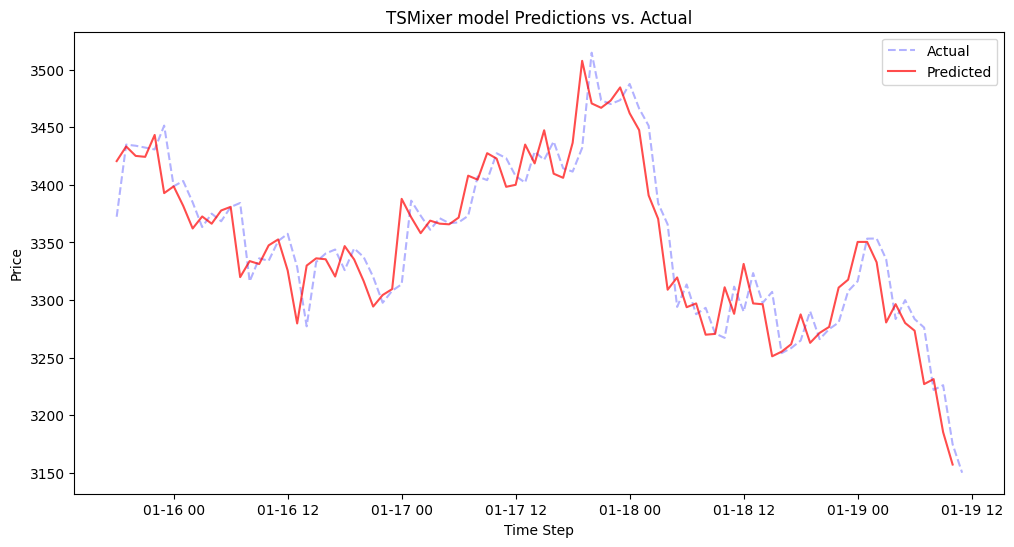

In [928]:
all_predictions = bt_best_params_test_data['TSMixerPredictions']
all_targets = bt_best_params_test_data['Close']
plot(all_predictions, all_targets, "TSMixer model Predictions vs. Actual")

In [929]:
class TechAnalysisWithTSMixerFilterStrategy(Strategy):
    def init(self) -> None:
        #self.data_loader = data_loader
        #self.model = model

        #self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')
        self.signal = self.I(lambda: self.data.Signal)
        self.tsmixer_prediction = self.I(lambda: self.data.TSMixerPredictions)
        self.previous_signal = 0

    def next(self) -> None:
        #if len(self.data) <= TSMIXER_CFG.WINDOW+1:
        #    return

        #scaled_prices = self.data_loader._make_dataset(
            #self.data_loader.scaler.transform(self.data.df[["Close"]][-(TSMIXER_CFG.WINDOW+1):]),
        #    self.data.df[["Close"]][-(TSMIXER_CFG.WINDOW+1):],
        #    shuffle=False
        #    )

        # predicted_close_price = self.data_loader.inverse_transform(
        #     self.model.predict(scaled_prices, verbose=0)[-1,:,:]
        #     )[0][0]
        #predicted_close_price = self.model.predict(scaled_prices, verbose=0)[-1,:,:][0][0]

        #self.forecasts[-1] = predicted_close_price
        
        current_signal = self.signal[-1]
        predicted_close_price = self.tsmixer_prediction[-1]

        if current_signal != self.previous_signal:
            if current_signal == 1 and self.data.Close[-1] < predicted_close_price:
                if self.position.is_short:
                    self.position.close()

                if not self.position.is_long:
                    self.buy()

            elif current_signal == -1 and self.data.Close[-1] > predicted_close_price:
                if self.position.is_long:
                    self.position.close()

                if not self.position.is_short:
                    self.sell()

            elif current_signal == 0:
                if self.data.Close[-1] < predicted_close_price:
                    if self.position.is_short:
                        self.position.close()
    
                    if not self.position.is_long:
                        self.buy()
                
                if self.data.Close[-1] > predicted_close_price:
                    if self.position.is_long:
                        self.position.close()
        
                    if not self.position.is_short:
                        self.sell()
                #if self.position:
                #    self.position.close()

        self.previous_signal = current_signal

In [930]:
bt_best_params_test_data

Open       High        Low      Close       Volume  \
Datetime                                                                       
2024-12-19 11:00:00 3707.60000 3712.99000 3697.09000 3705.62000  11556.95390   
2024-12-19 12:00:00 3705.62000 3710.20000 3674.40000 3679.73000  15833.57750   
2024-12-19 13:00:00 3679.73000 3699.31000 3673.48000 3678.39000  23140.95210   
2024-12-19 14:00:00 3678.39000 3702.51000 3634.34000 3638.59000  37906.70450   
2024-12-19 15:00:00 3638.59000 3640.94000 3572.73000 3613.92000  61338.98430   
...                        ...        ...        ...        ...          ...   
2025-01-19 07:00:00 3283.44000 3293.29000 3263.00000 3276.06000  25129.63590   
2025-01-19 08:00:00 3276.06000 3277.53000 3215.81000 3221.90000  47929.54510   
2025-01-19 09:00:00 3221.90000 3233.77000 3143.02000 3226.00000 105144.51170   
2025-01-19 10:00:00 3226.01000 3226.89000 3172.97000 3174.70000  51453.00680   
2025-01-19 11:00:00 3174.70000 3188.90000 3130.48000 3149.97000  50955.62760   

                     Signal  TSMixerPredictions  
Datetime                                         
2024-12-19 11:00:00       0          3674.45776  
2024-12-19 12:00:00       0          3674.09082  
2024-12-19 13:00:00       0          3635.85669  
2024-12-19 14:00:00       0          3612.83032  
2024-12-19 15:00:00      -1          3618.14160  
...                     ...                 ...  
2025-01-19 07:00:00      -1          3226.95312  
2025-01-19 08:00:00      -1          3231.28857  
2025-01-19 09:00:00      -1          3185.18213  
2025-01-19 10:00:00      -1          3157.06372  
2025-01-19 11:00:00      -1                 NaN  

[745 rows x 7 columns]

In [931]:
_ = run_backtest(bt_best_params_test_data, TechAnalysisWithTSMixerFilterStrategy)

Start                     2024-12-19 11:00:00
End                       2025-01-19 11:00:00
Duration                     31 days 00:00:00
Exposure Time [%]                    99.19463
Equity Final [$]                1514448.82816
Equity Peak [$]                 1514448.82816
Return [%]                           51.44488
Buy & Hold Return [%]               -14.99479
Return (Ann.) [%]                  6139.59486
Volatility (Ann.) [%]              4509.77070
Sharpe Ratio                          1.36140
Sortino Ratio                       279.77508
Calmar Ratio                        728.85399
Max. Drawdown [%]                    -8.42363
Avg. Drawdown [%]                    -1.85882
Max. Drawdown Duration        7 days 10:00:00
Avg. Drawdown Duration        0 days 20:00:00
# Trades                                   53
Win Rate [%]                         52.83019
Best Trade [%]                       10.43280
Worst Trade [%]                      -2.33419
Avg. Trade [%]                    